In [1]:
from __future__ import division
import numpy as np
import nibabel as nb
from ipywidgets import interact
from ipywidgets import widgets
import matplotlib.pyplot as plt
import scipy.ndimage
import tqdm
import glob
import os
%matplotlib inline

In [2]:
def plot_three(img, x, y, z):
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(img[:, :, z]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(img[:, y, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(img[x, :, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
              )

In [3]:
def show_image(path, x, y, z):
    img = nb.load(path).get_data()[..., 0]
    plot_three(img, x, y, z)
    mask = np.zeros_like(img, dtype=bool)
    mask[10:160, 120:190, 45:160] = 1
    img[~mask] = 0
    plot_three(img, x, y, z)
    segmentation_seed = np.zeros(img.shape, dtype=np.uint8)
    #segmentation_seed[img == 0] = 1
    #segmentation_seed[np.logical_and(img > 0, img < 300)] = 2
    segmentation_seed[np.logical_and(img > 650, img < 1000)] = 3
    segmentation_seed[np.logical_and(img > 1000, img < 1450)] = 4     
    plot_three(segmentation_seed, x, y, z)
    plt.figure()
    plt.hist(img[img > 0].flatten(), bins=256)
    plt.yscale('log', nonposy='clip')


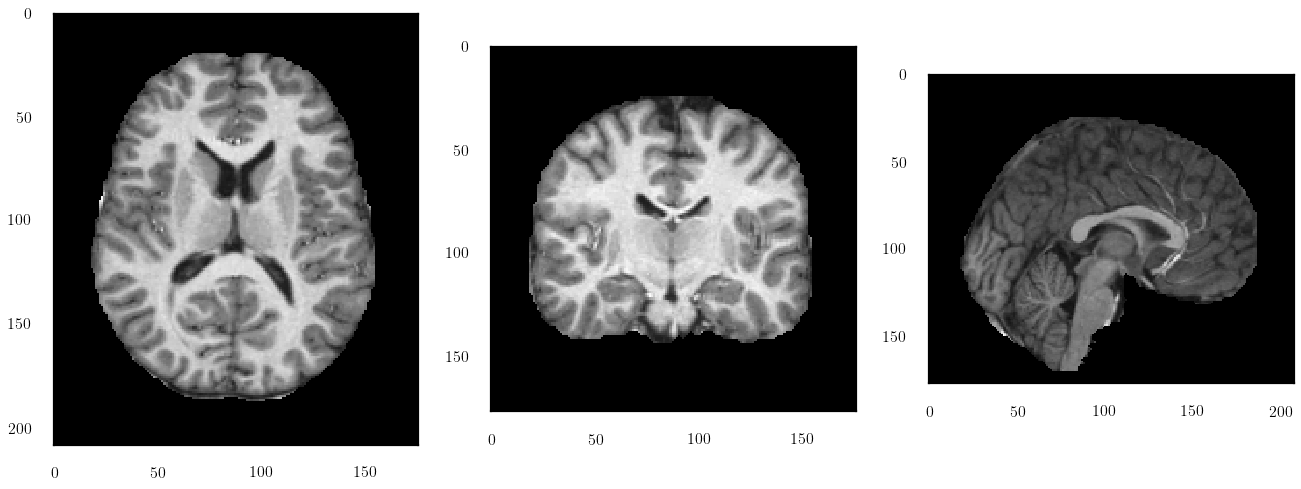

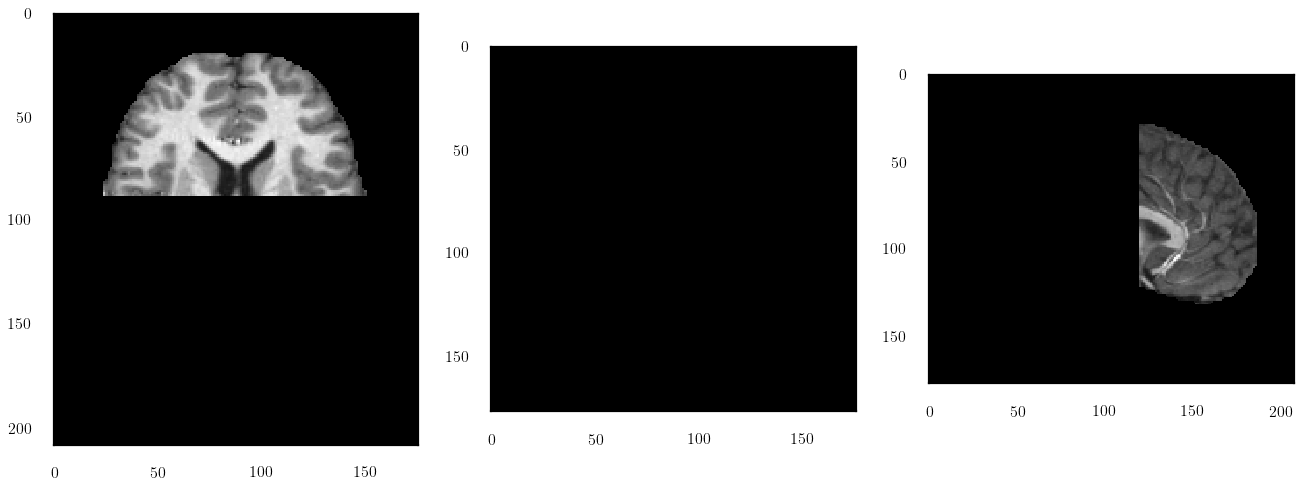

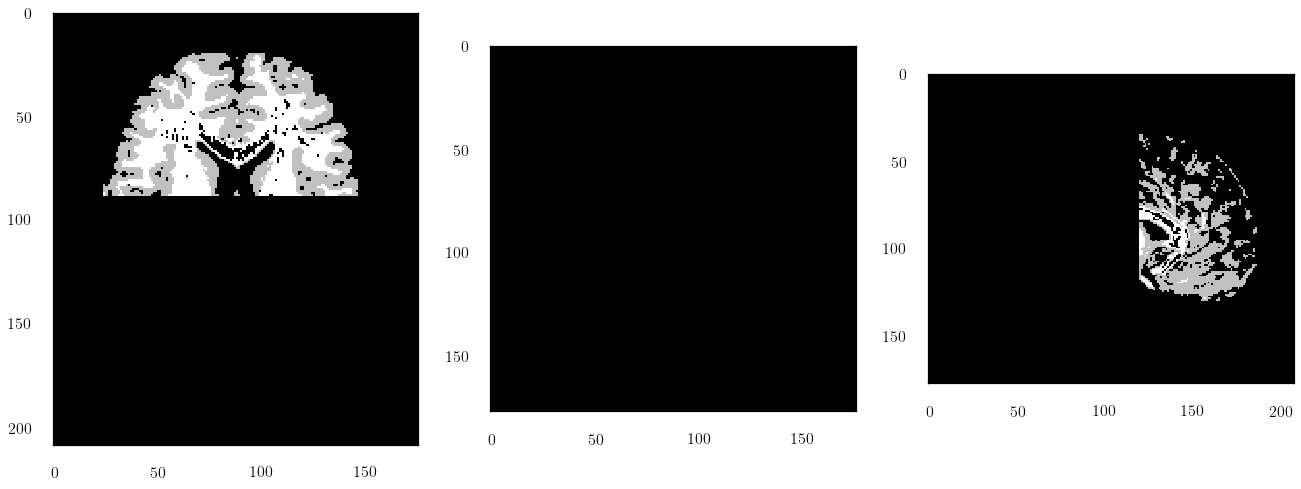

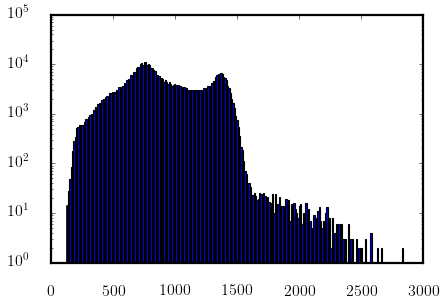

In [4]:
shape = (176, 208, 176)
path = widgets.Text("../data/set_train/train_1.nii")
interact(
    show_image,
    path=path,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
);

In [11]:
def solve_laplace(path):
    img = nb.load(path).get_data()[..., 0]
    # prefrontal cortex?
    img = img[10:160, 120:190, 45:160]
    seed = np.zeros(img.shape, dtype=float)
    seed[np.logical_and(img > 650, img < 1000)] = 500
    seed[img > 1000] = 1000
    mask = np.zeros(seed.shape, dtype=np.bool)
    mask[seed == 500] = 1
    n_iter = 0
    eps = 10000
    max_eps = 1e-3
    max_iter = 1000
    for i in range(max_iter):
        old = seed.copy()
        seed[1:-1, 1:-1, 1:-1] = (
            seed[0:-2, 1:-1, 1:-1] + seed[2:, 1:-1, 1:-1] +
            seed[1:-1, 0:-2, 1:-1] + seed[1:-1, 2:, 1:-1] +
            seed[1:-1, 1:-1, 0:-2] + seed[1:-1, 1:-1, 2:]
        ) / 6
        seed[~mask] = old[~mask]
        n_iter += 1
        update = (seed[mask] - old[mask]).flatten()
        eps = np.sqrt(np.dot(update, update))
        if eps < max_eps: break
    return seed

path = "../data/set_train/train_1.nii"
potential = solve_laplace(path)

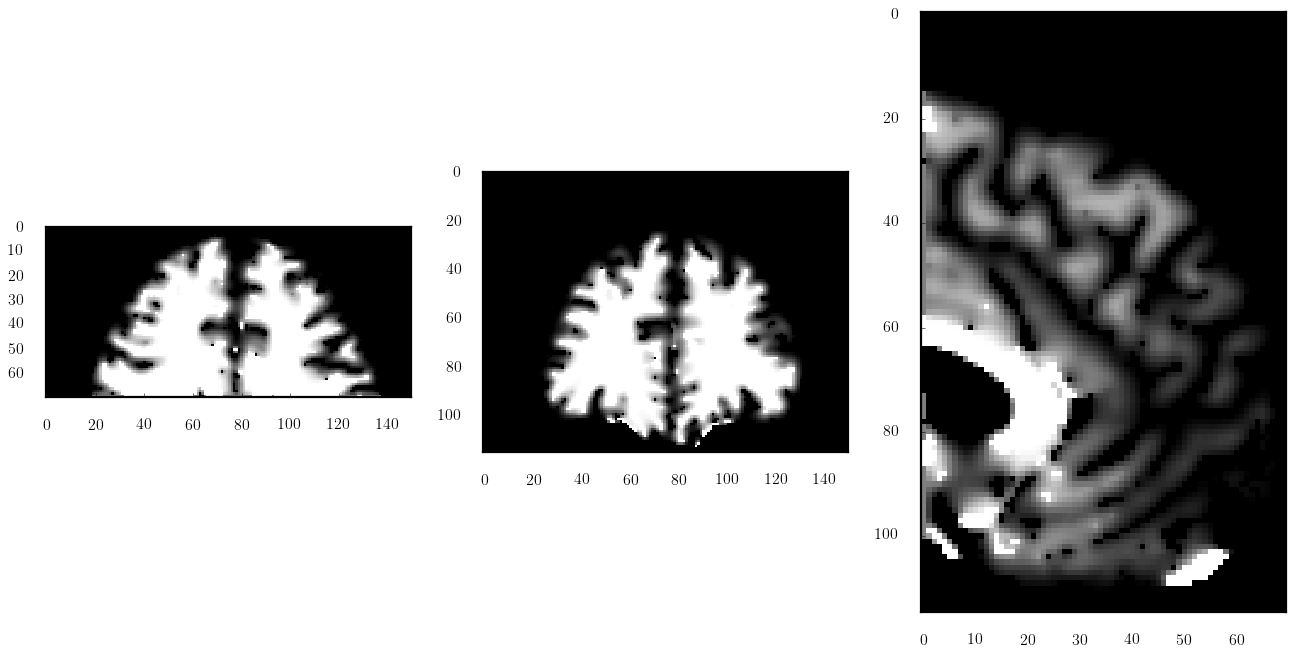

In [6]:
pot_shape = potential.shape

def plot_pot(x, y, z):
    plot_three(potential, x, y, z)

interact(
    plot_pot,
    x=widgets.IntSlider(min=0, max=pot_shape[0] - 1, step=1, value=pot_shape[0] // 2),
    y=widgets.IntSlider(min=0, max=pot_shape[1] - 1, step=1, value=pot_shape[1] // 2),
    z=widgets.IntSlider(min=0, max=pot_shape[2] - 1, step=1, value=pot_shape[2] // 2),
);

In [7]:
def cortical_thickness(potential):
    nx = (potential[1:, :-1, :-1] - potential[:-1, :-1, :-1]) / 2
    ny = (potential[:-1, 1:, :-1] - potential[:-1, :-1, :-1]) / 2
    nz = (potential[:-1, :-1, 1:] - potential[:-1, :-1, :-1]) / 2
    norm = np.sqrt(nx ** 2 + ny ** 2 + nz ** 2)
    nx /= norm
    ny /= norm
    nz /= norm
    nx[~np.isfinite(nx)] = 0
    ny[~np.isfinite(ny)] = 0
    nz[~np.isfinite(nz)] = 0
    ls = []
    max_l = 30
    for i in range(1, potential.shape[0] - 1):
        for j in range(1, potential.shape[1] - 1):
            for k in range(1, potential.shape[2] - 1):
                phi = potential[i, j, k]
                if phi == 0 or phi == 1000: continue
                x_0, y_0, z_0 = i, j, k
                l1 = 0
                while phi > 0 and l1 < max_l:
                    try:
                        x_1 = int(x_0 - nx[x_0, y_0, z_0])
                        y_1 = int(y_0 - ny[x_0, y_0, z_0])
                        z_1 = int(z_0 - nz[x_0, y_0, z_0])
                        phi = potential[x_1, y_1, z_1]
                        x_0, y_0, z_0 = x_1, y_1, z_1
                        l1 += 1
                    except (ValueError, OverflowError):
                        l1 = max_l
                x_0, y_0, z_0 = i, j, k
                phi = potential[i, j, k]
                l2 = 0
                while phi < 1000 and l2 < max_l and l1 < max_l:
                    try:
                        x_1 = int(x_0 + nx[x_0, y_0, z_0])
                        y_1 = int(y_0 + ny[x_0, y_0, z_0])
                        z_1 = int(z_0 + nz[x_0, y_0, z_0])
                        phi = potential[x_1, y_1, z_1]
                        x_0, y_0, z_0 = x_1, y_1, z_1
                        l2 += 1
                    except ValueError:
                        l2 = max_l
                if l1 < max_l and l2 < max_l:
                        ls.append((i, j, k, l1 + l2))
    return np.array(ls)

In [8]:
ls = cortical_thickness(potential)

/home/matteo/.pyenv/versions/machine-learning-healthy-brains/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/home/matteo/.pyenv/versions/machine-learning-healthy-brains/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/home/matteo/.pyenv/versions/machine-learning-healthy-brains/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/home/matteo/.pyenv/versions/machine-learning-healthy-brains/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/matteo/.pyenv/versions/machine-learning-healthy-brains/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/home/matteo/.pyenv/versions/machine-learning-healthy-brains/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid valu

In [9]:
thickness = np.zeros_like(potential)
for item in ls:
    i, j, k, l = item
    thickness[i, j, k] = l    
    
def plot_thick(x, y, z):
    print(np.size(thickness[thickness > 0]))
    plot_three(thickness, x, y, z)
    plot_three(potential, x, y, z)

    
plt.figure()
plt.hist(ls[..., 3], bins=20);
print(np.median(ls[..., 3]))

interact(
    plot_thick,
    x=widgets.IntSlider(min=0, max=pot_shape[0] - 1, step=1, value=pot_shape[0] // 2),
    y=widgets.IntSlider(min=0, max=pot_shape[1] - 1, step=1, value=pot_shape[1] // 2),
    z=widgets.IntSlider(min=0, max=pot_shape[2] - 1, step=1, value=pot_shape[2] // 2),
)

In [10]:
for file_name in tqdm.tqdm(glob.glob("../data/set_train/*.nii")):
    output_name = file_name.replace("set_train", "cortical_thickness").replace(".nii", ".npy")
    potential = solve_laplace(file_name)jkkk
    ls = cortical_thickness(potential)
    np.save(output_name, ls)